2021.03.19 運禽車軌跡

In [53]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString, shape
import folium
from folium import plugins
import datetime
# from polib.CsvEngn import *
%matplotlib inline

# 讀入 單一車輛/司機 資料

In [6]:
path = r"G:\我的雲端硬碟\work\2021\1.農試所_大禽流感專案\1.資料\車軌資料、家禽健康證明書\漢名_運禽車資料\行駛軌跡(025-H9)-210528160826.xls"
df = pd.read_excel(path, parse_dates=True ,usecols = "A:I" , skiprows=3)

In [7]:
df.head()

,車 號,車 機,司 機,GPS時間,經 度,緯 度,位 置,車 速,狀 態
0,025-H9,359841083374516,江祈安,2021/05/26 00:00:12,120.480687,23.667058,630台灣雲林縣斗南鎮信義路186-230號,0,熄火
1,025-H9,359841083374516,江祈安,2021/05/26 00:06:12,120.480652,23.667013,630台灣雲林縣斗南鎮信義路186-230號,0,熄火
2,025-H9,359841083374516,江祈安,2021/05/26 00:12:12,120.480688,23.667048,630台灣雲林縣斗南鎮信義路186-230號,0,熄火
3,025-H9,359841083374516,江祈安,2021/05/26 00:18:12,120.480673,23.667065,630台灣雲林縣斗南鎮信義路186-230號,0,熄火
4,025-H9,359841083374516,江祈安,2021/05/26 00:24:12,120.480677,23.667083,630台灣雲林縣斗南鎮信義路186-230號,0,熄火


In [14]:
df.rename(columns={"經 度":"X",
                   "緯 度":"Y",
                   "GPS時間":"GPSDATETIME"
                  }, inplace=True)

In [11]:
wgs84 = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.X, df.Y), crs=wgs84)

C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:>

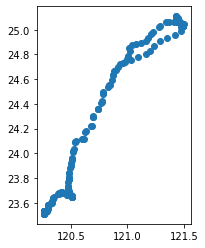

In [12]:
# 總行車軌跡
gdf.plot()

In [15]:
gdf.loc[:,"GPSDATETIME"] = pd.to_datetime(gdf.loc[:,"GPSDATETIME"])
gdf.loc[:,"date"] = gdf.loc[:,"GPSDATETIME"].dt.date

In [16]:
gdf.loc[:,"date"].unique()

array([datetime.date(2021, 5, 26), datetime.date(2021, 5, 27)],
      dtype=object)

## 挑出有移動行為的日期

In [17]:
# 以X座標的變化來判斷當天是否有出車
date_X_nuniq_df = gdf[["date", "X"]].groupby("date").X.nunique().reset_index()
date_X_nuniq_df

,date,X
0,2021-05-26,197
1,2021-05-27,216


## 判斷為有值勤的日期: 當日不重複X座標大於100個

In [18]:
move_date_lst = date_X_nuniq_df.loc[date_X_nuniq_df.X>100, "date"]
move_date_lst

0    2021-05-26
1    2021-05-27
Name: date, dtype: object

## 挑選日期

In [19]:
# mask = gdf.loc[:,"date"].isin([datetime.date(2020, 10, 9)]) 

#觀察每一天
mask = gdf.loc[:,"date"].isin(move_date_lst)
gdf_pic = gdf[mask].reset_index(drop=True)

計算點位之間的時間差、距離差

In [20]:
gdf_pic.loc[:,"position_lag1"] = gdf_pic.loc[:,"geometry"].shift(periods=1)
gdf_pic.to_crs('EPSG:5234')
gdf_pic.loc[:,"position_lag1_diff"] = gdf_pic["geometry"].distance(gdf_pic["position_lag1"])
gdf_pic.loc[:,"position_lag1_diff"].describe()

<ipython-input-20-b5c245ac6972>:3: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_pic.loc[:,"position_lag1_diff"] = gdf_pic["geometry"].distance(gdf_pic["position_lag1"])
<ipython-input-20-b5c245ac6972>:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: None

  gdf_pic.loc[:,"position_lag1_diff"] = gdf_pic["geometry"].distance(gdf_pic["position_lag1"])


count    504.000000
mean       0.014837
std        0.027611
min        0.000005
25%        0.000051
50%        0.000154
75%        0.015558
max        0.212489
Name: position_lag1_diff, dtype: float64

In [21]:
gdf_pic.loc[:,"time_lag1"] = gdf_pic.loc[:,"GPSDATETIME"].shift(periods=1)
gdf_pic.loc[:,"time_diff"] = (gdf_pic.loc[:,"GPSDATETIME"] - gdf_pic.loc[:,"time_lag1"])
gdf_pic.loc[:,"time_diff"].describe()

count                          504
mean     0 days 00:05:42.704365079
std      0 days 00:01:56.261727003
min                0 days 00:05:00
25%                0 days 00:05:01
50%                0 days 00:06:00
75%                0 days 00:06:00
max                0 days 00:46:04
Name: time_diff, dtype: object

In [23]:
# 運禽車的移動
gdf_pic.loc[:,"position_lag1_diff"].describe()

count    504.000000
mean       0.014837
std        0.027611
min        0.000005
25%        0.000051
50%        0.000154
75%        0.015558
max        0.212489
Name: position_lag1_diff, dtype: float64

In [32]:
gdf_pic["狀 態"].unique()

array(['熄火', '停留', '行駛中', '怠速', '超速', '國道超速'], dtype=object)

In [76]:
# 運禽車的每個點位的停留時間
mask_stay = gdf_pic["狀 態"].isin(['停留'])
gdf_pic.loc[mask_stay,"geometry_str"] = gdf_pic.loc[mask_stay,"geometry"].astype(str)
point_time_sum_df = gdf_pic.loc[mask_stay, ["geometry_str","time_diff"]].fillna(pd.Timedelta(seconds=0)).groupby("geometry_str",as_index=False).sum()
point_time_sum_df.loc[:, "X"] = point_time_sum_df.loc[:,"geometry_str"].apply(lambda p:
                                                                             float(p.split(" ")[1].replace("(","")))
point_time_sum_df.loc[:, "Y"] = point_time_sum_df.loc[:,"geometry_str"].apply(lambda p:
                                                                             float(p.split(" ")[2].replace(")","")))
point_time_sum_df.rename(columns={"time_diff":"time_sum"}, inplace=True)
point_time_sum_df['time_sum'].describe()

count                           63
mean     0 days 00:05:05.317460317
std      0 days 00:00:11.033417563
min                0 days 00:05:00
25%                0 days 00:05:00
50%                0 days 00:05:01
75%                0 days 00:05:03
max                0 days 00:05:50
Name: time_sum, dtype: object

In [77]:
# (option)計算每個點位最大/最小的時間
point_time_range_gp = gdf_pic.loc[mask_stay,["geometry_str","GPSDATETIME"]].groupby("geometry_str",as_index=False)
#min
point_time_min_df = point_time_range_gp.min()
point_time_min_df.rename(columns={"GPSDATETIME":"start_time"}, inplace=True)
#Max
point_time_max_df = point_time_range_gp.max()
point_time_max_df.rename(columns={"GPSDATETIME":"end_time"}, inplace=True)

# 合併
point_time_sum_maxmin_df = point_time_sum_df.merge(point_time_min_df, how="left", on="geometry_str")
point_time_sum_maxmin_df = point_time_sum_maxmin_df.merge(point_time_max_df, how="left", on="geometry_str")
point_time_sum_df = point_time_sum_maxmin_df.copy(deep=True)

In [78]:
# Timestamp -> formated str
point_time_sum_df.loc[:,"start_time"] = point_time_sum_df.loc[:,"start_time"].dt.strftime("%Y/%m/%d, %H:%M:%S")
point_time_sum_df.loc[:,"end_time"] = point_time_sum_df.loc[:,"end_time"].dt.strftime("%Y/%m/%d, %H:%M:%S")

In [79]:
point_time_sum_gdf = gpd.GeoDataFrame(
    point_time_sum_df, geometry=gpd.points_from_xy(point_time_sum_df.X, point_time_sum_df.Y), crs=wgs84)

C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### 停留點條件篩選: 停留5分鐘以上，2小時以下

In [80]:
point_time_sum_gdf.time_sum.describe()

count                           63
mean     0 days 00:05:05.317460317
std      0 days 00:00:11.033417563
min                0 days 00:05:00
25%                0 days 00:05:00
50%                0 days 00:05:01
75%                0 days 00:05:03
max                0 days 00:05:50
Name: time_sum, dtype: object

In [89]:
# 篩選條件 停留5分鐘以上，2小時以下
mask = (point_time_sum_gdf["time_sum"]>= datetime.timedelta(seconds=10, minutes=5, hours=0)) \
                & (point_time_sum_gdf["time_sum"]< datetime.timedelta(seconds=0, minutes=0, hours=2))

In [90]:
len(point_time_sum_gdf[mask])

10

## 畫圖

In [83]:
locations = point_time_sum_gdf[mask][['Y', 'X']]
locationlist = locations.values.tolist()

In [84]:
time_sums = point_time_sum_gdf[mask]['time_sum'].apply(lambda t: str(t).split("days")[1].split(".")[0])
time_sumslist = time_sums.values.tolist()

In [85]:
# (option)時間動畫

features = [{
    'geometry': {
        'coordinates': list(row['geometry'].coords)[0],
        'type': 'Point'
    },
    'properties': {
        'icon': 'marker',
        'iconstyle': {
            'iconSize': [40, 40],
            'iconUrl':
            'https://www.flaticon.com/svg/vstatic/svg/664/664468.svg?token=exp=1616138018~hmac=c04c6983e10730773e5f5f124f7b42e5'
        },
        'id': 'house',
        'popup': 1,
        'times': [row["start_time"],row["end_time"]]
    },
    'type': 'Feature'
}
    for idx,row in point_time_sum_gdf.iterrows()
]

In [86]:
map = folium.Map(location=[23.762485, 120.827323], 
                 zoom_start=8, 
                 tiles='http://tile.stamen.com/toner/{z}/{x}/{y}.png', 
                 attr="https://stackoverflow.com/questions/48318538/folium-custom-map-tiles"
                )

# 停留點聚合(如果太多)
# marker_cluster = plugins.MarkerCluster().add_to(map)

# 目標的停留時間 點位
for point in range(0, len(locationlist)):
    folium.CircleMarker(locationlist[point],
                        radius=10,
                        color='#3186cc',
                        fill=True,
                        popup=time_sumslist[point],
                        fill_color='#3186cc'
#                        ).add_to(marker_cluster)
                       ).add_to(map)

# 運禽車完整路線
folium.Choropleth(
    LineString(gdf_pic['geometry'].to_list()),
    line_weight=3,
    line_color='#66B3FF',
    name="行車軌跡"
).add_to(map)
    
    
# (option)加入時間
plugins.TimestampedGeoJson(
        {'type': 'FeatureCollection',
        'features': features}
        , period='PT2H' 
        , duration='PT1M'
        , add_last_point=False
        , auto_play=True
        , loop=False
        , max_speed=1
        , loop_button=True
        , date_options='YYYY/MM/DD HH:mm:ss'
        , time_slider_drag_update=True
    ).add_to(map)

# 加入底圖
folium.raster_layers.TileLayer(
    tiles = "https://wmts.nlsc.gov.tw/wmts/PHOTO2/default/GoogleMapsCompatible/{z}/{y}/{x}",                 
    attr = "國土測繪圖資服務雲",
    name="正射影像圖(通用版)",
#     overlay=True,
    min_zoom=0,
    max_zoom=19,
    ).add_to(map)
# folium.LayerControl().add_to(map)

folium.raster_layers.TileLayer(
    tiles = "https://wmts.nlsc.gov.tw/wmts/EMAP2/default/GoogleMapsCompatible/{z}/{y}/{x}",                 
    attr = "國土測繪圖資服務雲",
    name="臺灣通用電子地圖透明",
    show=False,
    overlay=True,
    min_zoom=0,
    max_zoom=19,
    ).add_to(map)
folium.LayerControl().add_to(map)

map